## 1、定义算法

Double DQN除了在更新时对期望Q值的近似方式与DQN不同之外，其他都是相同的


### 1.1、定义模型


In [1]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self, n_states,n_actions,hidden_dim=128):
        """ 初始化q网络，为全连接网络
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_states, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, n_actions) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 1.2、定义经验回放

经验回放首先是具有一定容量的，只有存储一定的transition网络才会更新，否则就退回到了之前的逐步更新了。另外写经验回放的时候一般需要包涵两个功能或方法，一个是push，即将一个transition样本按顺序放到经验回放中，如果满了就把最开始放进去的样本挤掉，因此如果大家学过数据结构的话推荐用队列来写，虽然这里不是。另外一个是sample，很简单就是随机采样出一个或者若干个（具体多少就是batch_size了）样本供DQN网络更新。功能讲清楚了，大家可以按照自己的想法用代码来实现，参考如下。

In [2]:
from collections import deque
import random
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放中
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

### 1.3、真定义算法

跟DQN算法几乎一模一样

In [3]:
import torch
import torch.optim as optim
import math
import numpy as np
class DoubleDQN(object):
    def __init__(self,cfg):
        self.states = cfg.n_states
        self.n_actions = cfg.n_actions  
        self.device = torch.device(cfg.device) 
        self.gamma = cfg.gamma  # 折扣因子
        # e-greedy策略相关参数
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon = cfg.epsilon_start
        self.sample_count = 0  
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.batch_size = cfg.batch_size
        self.target_update = cfg.target_update
        self.policy_net = MLP(cfg.n_states,cfg.n_actions,hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = MLP(cfg.n_states,cfg.n_actions,hidden_dim=cfg.hidden_dim).to(self.device)
         # 复制参数到目标网络
        for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
            target_param.data.copy_(param.data)
        # self.target_net.load_state_dict(self.policy_net.state_dict()) # or use this to copy parameters
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr)  # 优化器
        self.memory = ReplayBuffer(cfg.buffer_size) # 经验回放
        self.update_flag = False 

    def sample_action(self, state):
        ''' 采样动作
        '''
        self.sample_count += 1
        # epsilon指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        else:
            action = random.randrange(self.n_actions)
        return action
    @torch.no_grad() # 不计算梯度，该装饰器效果等同于with torch.no_grad()：
    def predict_action(self, state):
        ''' 预测动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        q_values = self.policy_net(state)
        action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 当经验回放中不满足一个批量时，不更新策略
            return
        else:
            if not self.update_flag:
                print("开始更新策略！")
                self.update_flag = True
        # 从经验回放中随机采样一个批量的转移(transition)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # 将数据转换为tensor
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)  
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float).unsqueeze(1)    
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device).unsqueeze(1)
        q_value_batch = self.policy_net(state_batch).gather(dim=1, index=action_batch) # 实际的Q值
        next_q_value_batch = self.policy_net(next_state_batch) # 下一个状态对应的实际策略网络Q值
        next_target_value_batch = self.target_net(next_state_batch) # 下一个状态对应的目标网络Q值
        # 将策略网络Q值最大的动作对应的目标网络Q值作为期望的Q值
        next_target_q_value_batch = next_target_value_batch.gather(1, torch.max(next_q_value_batch, 1)[1].unsqueeze(1))
        expected_q_value_batch = reward_batch + self.gamma * next_target_q_value_batch* (1-done_batch) # 期望的Q值
        # 计算损失
        loss = nn.MSELoss()(q_value_batch, expected_q_value_batch)
        # 优化更新模型
        self.optimizer.zero_grad()  
        loss.backward()
        # clip防止梯度爆炸
        for param in self.policy_net.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 
        if self.sample_count % self.target_update == 0: # 每隔一段时间，将策略网络的参数复制到目标网络
            self.target_net.load_state_dict(self.policy_net.state_dict())   


## 2、定义训练

In [4]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            agent.memory.push((state, action, reward,next_state, done))  # 保存transition
            state = next_state  # 更新下一个状态
            agent.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，Epislon：{agent.epsilon:.3f}")
    print("完成训练！")
    env.close()
    return {'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

## 3. 定义环境

In [5]:
import gym
import os
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    # 更新n_states和n_actions到cfg参数中
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    agent = DoubleDQN(cfg)
    return env,agent

## 4、设置参数

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self):
        self.algo_name = 'DoubleDQN' # 算法名称
        self.env_name = 'CartPole-v1' # 环境名称
        self.seed = 1 # 随机种子
        self.train_eps = 100 # 训练回合数
        self.test_eps = 10  # 测试回合数
        self.max_steps = 200 # 每回合最大步数
        self.gamma = 0.99 # 折扣因子
        self.lr = 0.0001 # 学习率
        self.epsilon_start = 0.95 # epsilon初始值
        self.epsilon_end = 0.01 # epsilon最终值
        self.epsilon_decay = 500 # epsilon衰减率
        self.buffer_size = 10000 # ReplayBuffer容量
        self.batch_size = 64 # ReplayBuffer中批次大小
        self.target_update = 4 # 目标网络更新频率
        self.hidden_dim = 256 # 神经网络隐藏层维度
        if torch.cuda.is_available(): # 是否使用GPUs
            self.device = 'cuda'
        else:
            self.device = 'cpu'
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

def print_cfgs(cfg):
    ''' 打印参数
    '''
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))


## 5、开始训练

Hyperparameters:
        Name        	       Value        	        Type        
     algo_name      	     DoubleDQN      	   <class 'str'>    
      env_name      	    CartPole-v1     	   <class 'str'>    
        seed        	         1          	   <class 'int'>    
     train_eps      	        100         	   <class 'int'>    
      test_eps      	         10         	   <class 'int'>    
     max_steps      	        200         	   <class 'int'>    
       gamma        	        0.99        	  <class 'float'>   
         lr         	       0.0001       	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
    buffer_size     	       10000        	   <class 'int'>    
     batch_size     	         64         	   <class 'int'>    
   target_update    	         4          	   <class 'int'>    
     hidden_dim     	        256      

/home/uih/anaconda3/envs/torch2/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/uih/anaconda3/envs/torch2/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/uih/anaconda3/envs/torch2/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


开始训练！
开始更新策略！
回合：10/100，奖励：24.00，Epislon：0.663
回合：20/100，奖励：10.00，Epislon：0.508
回合：30/100，奖励：10.00，Epislon：0.395
回合：40/100，奖励：10.00，Epislon：0.308
回合：50/100，奖励：46.00，Epislon：0.222
回合：60/100，奖励：87.00，Epislon：0.057
回合：70/100，奖励：37.00，Epislon：0.025
回合：80/100，奖励：106.00，Epislon：0.013
回合：90/100，奖励：159.00，Epislon：0.010
回合：100/100，奖励：200.00，Epislon：0.010
完成训练！
开始测试！
回合：1/10，奖励：200.00
回合：2/10，奖励：200.00
回合：3/10，奖励：137.00


/tmp/ipykernel_49002/802251170.py:39: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0, len(rewards), 10)  # 设置x轴的范围


回合：4/10，奖励：200.00
回合：5/10，奖励：139.00
回合：6/10，奖励：200.00
回合：7/10，奖励：200.00
回合：8/10，奖励：200.00
回合：9/10，奖励：200.00
回合：10/10，奖励：200.00
完成测试


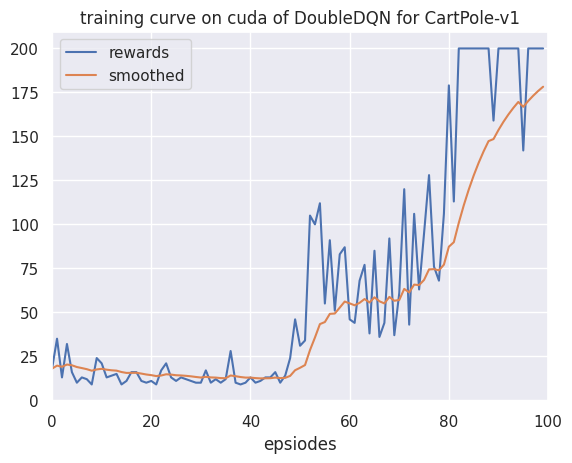

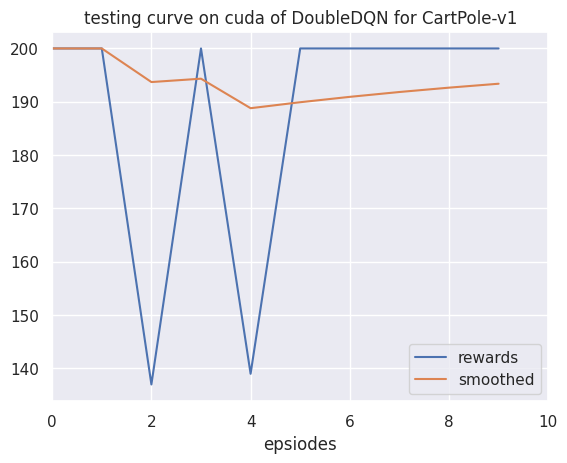

In [7]:
# 获取参数
cfg = Config() 
print_cfgs(cfg)
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # 画出结果